# Run cell mapping: CellTrek

## Imports

In [ ]:
global_path <- './cell-cell-communication/'


In [1]:
.libPaths('/home/epareja/miniconda3/envs/r4-cellchat/lib/R/library')

library(dior)
library(anndata)
library(dplyr)
library(CellChat)
library(patchwork)
options(stringsAsFactors = FALSE)
library(Seurat)
library(SeuratData)
library(SeuratDisk)
library(reticulate)
library(CellTrek)
library(viridis)
library(ConsensusClusterPlus)

patient <- 'CID4535'

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)


Attaching package: ‘anndata’


The following object is masked from ‘package:dior’:

    read_h5ad



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘CellChat’ was built under R version 4.2.1”
Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union



## Load the data

### This is only necesary if you work with scanpy so you have the data as h5ad


In [2]:

ad <- import("anndata", convert = FALSE) # you need to have installed anndata 
file_path <- sprintf("%sData/Breast/adata_patients/adata_ref_%s.h5ad", global_path, patient)
ad_object <- ad$read_h5ad(file_path)# access normalized data matrix of the specific patient
data.input <- t(py_to_r(ad_object$X)) # Here you need the genes in the rows
rownames(data.input) <- rownames(py_to_r(ad_object$var))
colnames(data.input) <- rownames(py_to_r(ad_object$obs))
# access meta data
meta.data <- py_to_r(ad_object$obs)
meta <- meta.data

seurat_ref <- CreateSeuratObject(counts = as.data.frame(data.input))
seurat_ref <- RenameCells(seurat_ref, new.names=make.names(Cells(seurat_ref)))
seurat_ref[['cell_names']] <- meta$celltype_minor

In [2]:
## I convert the h5ad file to .h5 using diopy and now I can read it and create a Seurat object
file_path_spatial <- sprintf("%sData/Breast/spatial_objects/sp_data_%s.h5", global_path, patient) # path to the spatial data for the specific patient
adata = read_h5(file = file_path_spatial, 
                assay.name = 'spatial')
adata <- RenameCells(adata, new.names=make.names(Cells(adata)))
adata$orig.ident <- "Visium"


## Run CellTrek


In [8]:
breast_traint <- CellTrek::traint(st_data=adata, sc_data=seurat_ref, sc_assay='RNA')


Finding transfer anchors... 


No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



Using 2000 features for integration... 


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6427 anchors

Filtering anchors

	Retained 2947 anchors



Data transfering... 


Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



Creating new Seurat object... 
Scaling -> PCA -> UMAP... 


Centering and scaling data matrix

PC_ 1 
Positive:  KRT19, CD24, TSTD1, S100A14, KRT18, SCGB2A2, KRT8, AZGP1, S100A1, CLDN3 
	   CLDN4, CALML5, SPINT2, CRABP2, ELF3, MGST1, PIP, AGR2, PYCARD, KRT7 
	   SCGB1D2, CLU, MT-CO2, PPDPF, PERP, DSP, GATA3, TRPS1, TACSTD2, SCGB2A1 
Negative:  VIM, SPARC, B2M, IGFBP7, MMP2, CALD1, COL6A2, HLA-B, HTRA1, BGN 
	   IFI27, SPARCL1, COL1A2, HLA-A, TCF4, COL3A1, COL6A1, COL1A1, FN1, SERPINF1 
	   MARCKS, CTHRC1, THY1, VCAN, LUM, DCN, COL6A3, COL5A2, TIMP3, AEBP1 
PC_ 2 
Positive:  HLA-DRA, HLA-DPA1, HLA-DPB1, TYROBP, HLA-DRB5, HLA-DRB1, HLA-DQB1, CD74, C1QB, C1QA 
	   C1QC, HLA-DQA1, CCL3, RGS1, LAPTM5, LYZ, AIF1, CCL4, SRGN, FCER1G 
	   HLA-DMA, MS4A6A, CCL4L2, HLA-DQA2, CD68, TREM2, CD83, OLR1, APOC1, ALOX5AP 
Negative:  COL1A1, COL1A2, COL3A1, LUM, COL6A3, DCN, AEBP1, COL5A2, COL6A1, POSTN 
	   CTSK, CTHRC1, COL6A2, RARRES2, SFRP2, IGFBP4, BGN, MXRA8, FBLN1, ASPN 
	   THBS2, COL5A1, CALD1, COL12A1, ISLR, C1S, MFAP2, THY1, COL11A1, FBLN2 
PC_ 3 
Pos

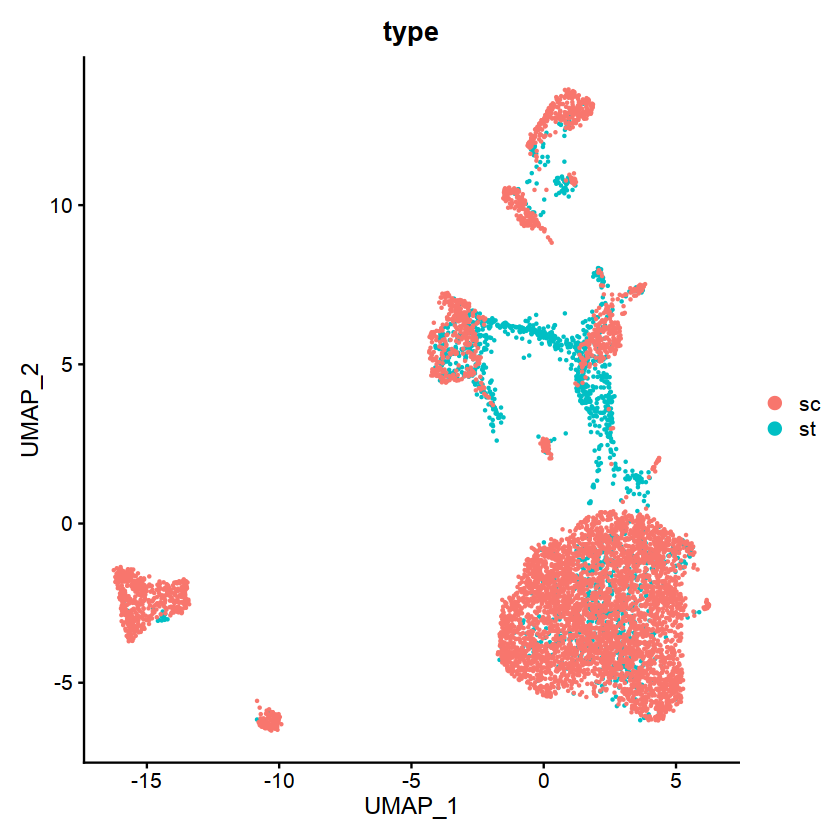

In [9]:
DimPlot(breast_traint, group.by = "type") 


## Assign cells to spatial location

In [ ]:
breast_celltrek <- CellTrek::celltrek(st_sc_int=breast_traint, int_assay='traint', sc_data=seurat_ref, sc_assay = 'RNA', 
                                   reduction='pca', intp=T, intp_pnt=5000, intp_lin=F, nPCs=30, ntree=1000, 
                                   dist_thresh=0.55, top_spot=1, spot_n=5, repel_r=20, repel_iter=20, keep_model=T)$celltrek

### top_spot to change the number of times a cell can be mapped to a spot      

file_path_result <- sprintf("%sResults/Breast/CellTrek/meta_cellcharting_%s.csv", global_path, patient)
write.csv(breast_celltrek@meta.data, file_path_result, row.names=TRUE)

## Explore cell annotation

In [ ]:
CellTrek::celltrek_vis(breast_celltrek@meta.data %>% dplyr::select(coord_x, coord_y, cell_names:id_new),
                       breast_celltrek@images$breast_tissue@image, breast_celltrek@images$breast_tissue@scale.factors$lowres)